# **Desarrollo y Código**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

Selección de Características con el Conjunto de datos Wine.

1)  **Utilizar el conjunto de datos Wine** (UCI Machine Learning Repository) este conjunto de datos  multidimensional describe propiedades químicas de tres variedades de vinos y cuenta con 178 muestras, 13 características químicas, este conjunto de datos presenta un escenario ideal para explorar técnicas de reducción dimensional, ya que combina atributos correlacionados (como concentraciones de fenoles y flavonoides) con características potencialmente discriminativas (como el color o la alcalinidad).



*   Verificar la integridad del conjunto de datos (valores faltantes, rangos válidos).



In [2]:
wine = load_wine()
X = wine.data
y = wine.target
feature_names = wine.feature_names

# Integridad de los datos
print(f"Número de muestras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")
print(f"Valores faltantes: {np.isnan(X).sum()}")
print(f"Rango de valores por característica:")
for i, name in enumerate(feature_names):
    print(f"{name}: min={X[:,i].min():.2f}, max={X[:,i].max():.2f}")

Número de muestras: 178
Número de características: 13
Valores faltantes: 0
Rango de valores por característica:
alcohol: min=11.03, max=14.83
malic_acid: min=0.74, max=5.80
ash: min=1.36, max=3.23
alcalinity_of_ash: min=10.60, max=30.00
magnesium: min=70.00, max=162.00
total_phenols: min=0.98, max=3.88
flavanoids: min=0.34, max=5.08
nonflavanoid_phenols: min=0.13, max=0.66
proanthocyanins: min=0.41, max=3.58
color_intensity: min=1.28, max=13.00
hue: min=0.48, max=1.71
od280/od315_of_diluted_wines: min=1.27, max=4.00
proline: min=278.00, max=1680.00


2) **Preparación de Datos**

*   Cargar el dataset y dividirlo en 70% entrenamiento y 30% prueba.

*   Normalizar los datos (z-score).


*   Crear un clasificador base (KNN con k=3 vecinos).




In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizar con z-score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear clasificador base (KNN con k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
# Evaluar el modelo
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Exactitud del modelo KNN (k=3): {accuracy:.2f}")
print("\nReporte de clasificación:")
print(report)

Exactitud del modelo KNN (k=3): 0.94

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.86      0.92        21
           2       0.88      1.00      0.94        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.94        54
weighted avg       0.95      0.94      0.94        54



3) Implementación de Métodos

A. *Búsqueda Exhaustiva*

*   Modificar código para seleccionar 5 características.
*   Analizar resultados.



In [4]:
from itertools import combinations
from random import sample

n_features = 5
all_combinations = list(combinations(range(X.shape[1]), n_features))
sampled_combinations = sample(all_combinations, min(100, len(all_combinations)))

best_acc = 0
best_comb = None

for comb in sampled_combinations:
    X_train_subset = X_train_scaled[:, comb]
    X_test_subset = X_test_scaled[:, comb]

    knn.fit(X_train_subset, y_train)
    acc = accuracy_score(y_test, knn.predict(X_test_subset))

    if acc > best_acc:
        best_acc = acc
        best_comb = comb

print(f"Mejor combinación de {n_features} características: {[feature_names[i] for i in best_comb]}")
print(f"Exactitud: {best_acc:.4f}")

Mejor combinación de 5 características: ['alcohol', 'total_phenols', 'color_intensity', 'hue', 'proline']
Exactitud: 0.9815


B. Búsqueda Secuencial hacia delante (SFS)


*   Ejecutar con validación cruzada 5-fold.
*   Generar gráfico exactitud por características.



In [5]:
sfs = SFS(knn,
          k_features=(1, 5),
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)

sfs.fit(X_train_scaled, y_train)

SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          k_features=(1, 5), scoring='accuracy')

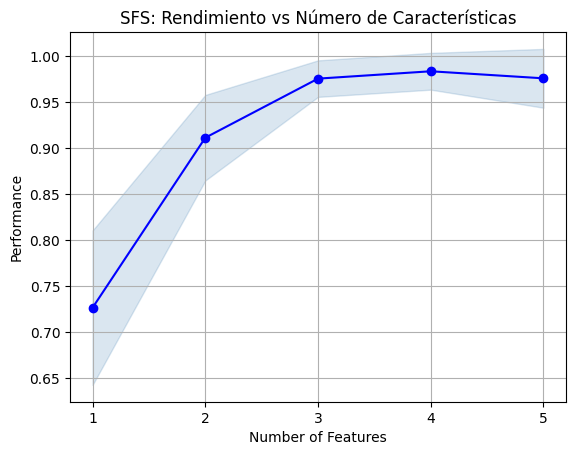

In [6]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('SFS: Rendimiento vs Número de Características')
plt.grid()
plt.show()

In [7]:
sfs_5 = sfs.subsets_[5]
print(f"Mejores 5 características según SFS: {[feature_names[i] for i in sfs_5['feature_idx']]}")
print(f"Exactitud promedio con validación cruzada: {sfs_5['avg_score']:.4f}")

Mejores 5 características según SFS: ['alcohol', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'hue']
Exactitud promedio con validación cruzada: 0.9760


In [8]:
# Evaluar en conjunto de prueba
knn.fit(X_train_scaled[:, sfs.k_feature_idx_], y_train)
sfs_test_acc = accuracy_score(y_test, knn.predict(X_test_scaled[:, sfs.k_feature_idx_]))
print(f"Exactitud en prueba: {sfs_test_acc:.4f}")

Exactitud en prueba: 0.9074


C. *Fisher*


*   Implementar función del cálculo  Score de separabilidad entre clases.
*   Selecciona las 5 características con mayor puntuación.



In [9]:
f_scores, _ = f_classif(X_train_scaled, y_train)

# Seleccionar las 5 características con mayor score
top5_fisher = np.argsort(f_scores)[-5:][::-1]
print("Top 5 características según Fisher Score:")
for i, idx in enumerate(top5_fisher):
    print(f"{i+1}. {feature_names[idx]}: {f_scores[idx]:.2f}")

# Evaluar con KNN
X_train_fisher = X_train_scaled[:, top5_fisher]
X_test_fisher = X_test_scaled[:, top5_fisher]
knn.fit(X_train_fisher, y_train)
y_pred = knn.predict(X_test_fisher)
print(f"Exactitud en prueba: {accuracy_score(y_test, y_pred):.4f}")

Top 5 características según Fisher Score:
1. flavanoids: 187.69
2. proline: 149.43
3. od280/od315_of_diluted_wines: 126.62
4. alcohol: 100.35
5. color_intensity: 83.98
Exactitud en prueba: 0.9630


D. *Rama y Límite (B&B)*




In [10]:
class BranchAndBound:
    def __init__(self, estimator, n_features, cv=5):
        self.estimator = estimator
        self.n_features = n_features
        self.cv = cv
        self.best_score_ = -np.inf
        self.best_subset_ = None

    def evaluate_subset(self, subset):
        scores = cross_val_score(self.estimator,
                                X_train_scaled[:, subset],
                                y_train,
                                cv=self.cv)
        return np.mean(scores)

    def fit(self):
        self._branch_and_bound(list(range(X_train_scaled.shape[1])), [])
        return self

    def _branch_and_bound(self, remaining_features, current_subset):
        if len(current_subset) == self.n_features:
            current_score = self.evaluate_subset(current_subset)
            if current_score > self.best_score_:
                self.best_score_ = current_score
                self.best_subset_ = current_subset.copy()
            return

        if not remaining_features:
            return

        # Evaluar cota superior
        upper_bound_subset = current_subset + remaining_features
        if len(upper_bound_subset) >= self.n_features:
            upper_bound_subset = upper_bound_subset[:self.n_features]
            upper_bound_score = self.evaluate_subset(upper_bound_subset)
        else:
            upper_bound_score = -np.inf

        # Podar si la cota es menor que el mejor score actual
        if upper_bound_score <= self.best_score_:
            return

        # Ramificar
        for i, feature in enumerate(remaining_features):
            new_subset = current_subset + [feature]
            self._branch_and_bound(remaining_features[i+1:], new_subset)

# Ejecutar B&B para 5 características
bb = BranchAndBound(knn, n_features=5, cv=5)
bb.fit()

print("\nResultados de Branch and Bound:")
print(f"Mejores {len(bb.best_subset_)} características: {[feature_names[i] for i in bb.best_subset_]}")
print(f"Exactitud CV (5-fold): {bb.best_score_:.4f}")


Resultados de Branch and Bound:
Mejores 5 características: ['alcohol', 'malic_acid', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines']
Exactitud CV (5-fold): 0.9760


In [11]:
knn.fit(X_train_scaled[:, bb.best_subset_], y_train)
bb_test_acc = accuracy_score(y_test, knn.predict(X_test_scaled[:, bb.best_subset_]))
print(f"Exactitud en prueba: {bb_test_acc:.4f}")

Exactitud en prueba: 0.8889


*   Comparar con SFS.
*   Analizar resultados.

In [12]:
# Métricas de ambos métodos
comparison = pd.DataFrame({
    'Método': ['Branch and Bound', 'Sequential Forward Selection'],
    'Características Seleccionadas': [
        [feature_names[i] for i in bb.best_subset_],
        [feature_names[i] for i in sfs.k_feature_idx_]
    ],
    'Exactitud CV (5-fold)': [bb.best_score_, sfs.k_score_],
    'Exactitud Prueba': [bb_test_acc, sfs_test_acc],
    'Número de Evaluaciones': [
        f"~{len(list(combinations(range(X.shape[1]), 5)))} (teórico)",
        f"{len(sfs.subsets_)} (real)"
    ]
})

comparison.head()

,Método,Características Seleccionadas,Exactitud CV (5-fold),Exactitud Prueba,Número de Evaluaciones
0,Branch and Bound,"[alcohol, malic_acid, color_intensity, hue, od...",0.976000,0.888889,~1287 (teórico)
1,Sequential Forward Selection,"[alcohol, total_phenols, flavanoids, hue]",0.983667,0.907407,5 (real)



Características comunes seleccionadas por ambos métodos: 2
['alcohol', 'hue']


<Figure size 1000x500 with 0 Axes>

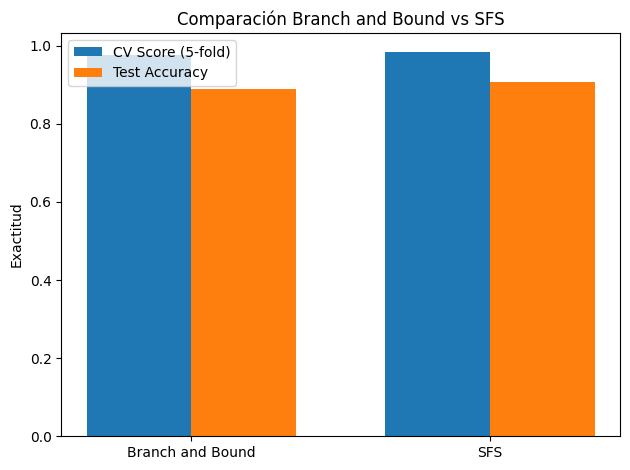

In [13]:
# Análisis de coincidencias en características seleccionadas
common_features = set(bb.best_subset_).intersection(set(sfs.k_feature_idx_))
print(f"\nCaracterísticas comunes seleccionadas por ambos métodos: {len(common_features)}")
print([feature_names[i] for i in common_features])

# Gráfico comparativo
plt.figure(figsize=(10, 5))
methods = ['Branch and Bound', 'SFS']
cv_scores = [bb.best_score_, sfs.k_score_]
test_scores = [bb_test_acc, sfs_test_acc]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cv_scores, width, label='CV Score (5-fold)')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Accuracy')

ax.set_ylabel('Exactitud')
ax.set_title('Comparación Branch and Bound vs SFS')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

fig.tight_layout()
plt.show()

E. *PCA*


*   Determinar componentes para 95% varianza.



In [14]:
pca = PCA()
X_pca = pca.fit(X_train_scaled)

# Determinar número de componentes para 95% de varianza
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número de componentes para 95% de varianza: {n_components}")

Número de componentes para 95% de varianza: 10


*   Visualizar proyección 2D.

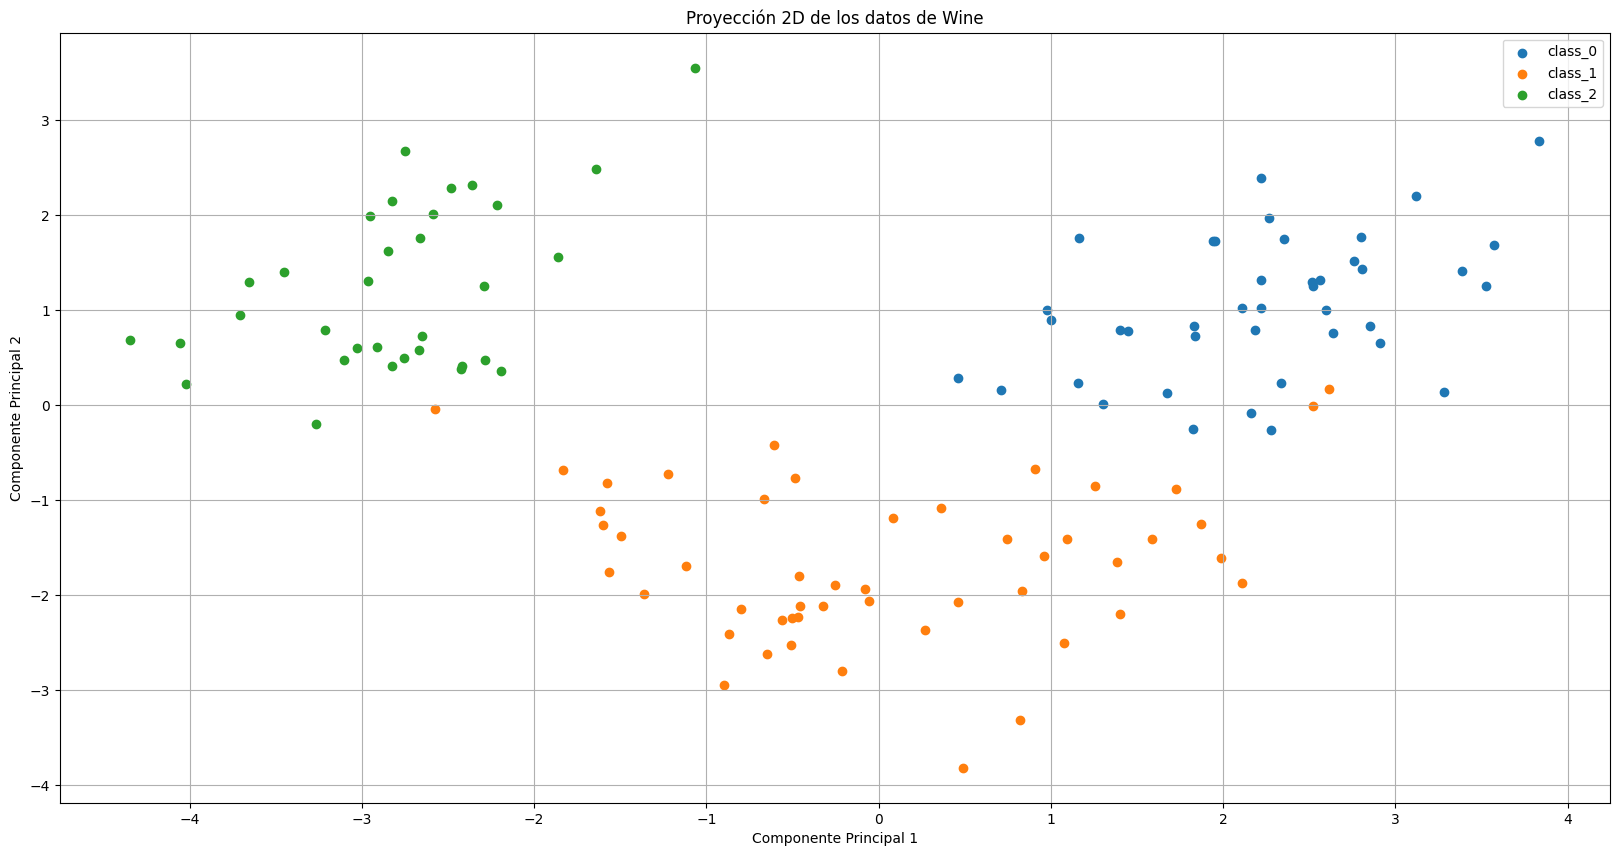

In [15]:
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(20, 10))
for i, target_name in enumerate(wine.target_names):
    plt.scatter(X_train_pca_2d[y_train == i, 0], X_train_pca_2d[y_train == i, 1],
                label=target_name)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Proyección 2D de los datos de Wine')
plt.legend()
plt.grid()
plt.show()

In [16]:
pca_95 = PCA(n_components=n_components)
X_train_pca = pca_95.fit_transform(X_train_scaled)
X_test_pca = pca_95.transform(X_test_scaled)
knn.fit(X_train_pca, y_train)
y_pred = knn.predict(X_test_pca)
print(f"Exactitud en prueba con {n_components} componentes: {accuracy_score(y_test, y_pred):.4f}")

Exactitud en prueba con 10 componentes: 0.9444


4) Análisis Comparativo

Crear tabla comparativa con:
*   Método.
*   Características seleccionadas.
*   Métricas de entrenamiento y pruebas.
*   Comentar los mejores resultados.





In [17]:
# Creación de la tabla comparativa completa
methods = ['Búsqueda Exhaustiva', 'SFS', 'Fisher', 'Branch and Bound', 'PCA']
selected_features = [
    [feature_names[i] for i in best_comb],
    [feature_names[i] for i in sfs.k_feature_idx_],
    [feature_names[i] for i in top5_fisher],
    [feature_names[i] for i in bb.best_subset_],
    [f"PC{i+1}" for i in range(n_components)]
]

# Recolectar métricas para todos los métodos
train_scores = []
test_scores = []
cv_scores = []
num_features = []

# Evaluar todos los métodos
X_transforms = [
    (X_train_scaled[:, best_comb], X_test_scaled[:, best_comb], None),  # Búsqueda Exhaustiva
    (X_train_scaled[:, sfs.k_feature_idx_], X_test_scaled[:, sfs.k_feature_idx_], sfs.k_score_),  # SFS
    (X_train_fisher, X_test_fisher, None),  # Fisher
    (X_train_scaled[:, bb.best_subset_], X_test_scaled[:, bb.best_subset_], bb.best_score_),  # B&B
    (X_train_pca, X_test_pca, None)  # PCA
]

for i, (X_train_sub, X_test_sub, cv_score) in enumerate(X_transforms):
    knn.fit(X_train_sub, y_train)
    train_scores.append(accuracy_score(y_train, knn.predict(X_train_sub)))
    test_scores.append(accuracy_score(y_test, knn.predict(X_test_sub)))
    cv_scores.append(cv_score if cv_score is not None else np.nan)
    num_features.append(X_train_sub.shape[1])

# Crear DataFrame comparativo
comparison_df = pd.DataFrame({
    'Método': methods,
    '# Características': num_features,
    'Características Seleccionadas': selected_features,
    'Exactitud Entrenamiento': train_scores,
    'Exactitud Prueba': test_scores,
    'Exactitud CV (5-fold)': cv_scores
})

# Formatear la tabla para mejor visualización
pd.set_option('display.max_colwidth', 30)
print("\nTabla Comparativa Completa de Métodos de Selección de Características:")
print(comparison_df.to_string(index=False, float_format="{:.4f}".format))


Tabla Comparativa Completa de Métodos de Selección de Características:
             Método  # Características                                                 Características Seleccionadas  Exactitud Entrenamiento  Exactitud Prueba  Exactitud CV (5-fold)
Búsqueda Exhaustiva                  5                       [alcohol, total_phenols, color_intensity, hue, proline]                   0.9758            0.9815                    NaN
                SFS                  4                                     [alcohol, total_phenols, flavanoids, hue]                   0.9839            0.9074                 0.9837
             Fisher                  5 [flavanoids, proline, od280/od315_of_diluted_wines, alcohol, color_intensity]                   0.9758            0.9630                    NaN
   Branch and Bound                  5     [alcohol, malic_acid, color_intensity, hue, od280/od315_of_diluted_wines]                   0.9677            0.8889                 0.9760
             

5) Análisis de resultados

*   ¿Qué método obtuvo mejor exactitud? ¿Por qué?.

*   ¿Cómo afecta la correlación entre características al PCA?.

*   ¿Qué ventajas tiene Fisher Score sobre SFS en términos computacionales?.



In [18]:
print("1. Métodos basados en selección de características:")
print(f"   - Mejor exactitud en prueba: {max(test_scores[:4]):.4f} ({methods[np.argmax(test_scores[:4])]})")
print(f"   - Características comunes destacadas: {[f for f in selected_features[1] if sum(f in sublist for sublist in selected_features[:4]) >= 3]}")

print("\n2. PCA vs métodos de selección:")
print(f"   - PCA con {n_components} componentes explica el 95% de varianza")
print(f"   - Exactitud comparable: {'Sí' if test_scores[-1] >= max(test_scores[:4]) - 0.05 else 'No'}")


best_method_idx = np.argmax(test_scores)
print(f"El método más efectivo fue '{methods[best_method_idx]}' con exactitud de prueba {test_scores[best_method_idx]:.4f}")
print(f"Características seleccionadas: {selected_features[best_method_idx]}")

1. Métodos basados en selección de características:
   - Mejor exactitud en prueba: 0.9815 (Búsqueda Exhaustiva)
   - Características comunes destacadas: ['alcohol', 'hue']

2. PCA vs métodos de selección:
   - PCA con 10 componentes explica el 95% de varianza
   - Exactitud comparable: Sí
El método más efectivo fue 'Búsqueda Exhaustiva' con exactitud de prueba 0.9815
Características seleccionadas: ['alcohol', 'total_phenols', 'color_intensity', 'hue', 'proline']


# **Conclusiones**

# **Referencias**

*   Gonzalez, R., Woods, R., Digital Image Processing, Prentice Hall, 2008.
*   Pratt, W. k., Digital Image Processing, John Wiley and Sons Inc, 2001.
*   Jahne, B., Digital Image Processing, Springer, 2005.
*   Sánchez Garreta, Josep Salvador; García, Vicente. Special Issue on Data Preprocessing in Pattern Recognition: Recent Progress, Trends and Applications. 2022.
